In [ ]:
import os
import sys
from copy import deepcopy

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

from hydra import initialize
try:
    initialize(version_base=None, config_path="../sam2_logs/", job_name="predict_run")
except ValueError:
    pass

import cv2
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import supervision as sv
import torch
from torch.amp import autocast
from torchvision.transforms import ToPILImage, ToTensor, Normalize
from training.dataset.transforms import ComposeAPI, NormalizeAPI

from helpers.configurations import TRACK_TO_METAINFO, LABEL_PROJECTION_MAP
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from custom_model_builder import build_sam2former

/home/guests/tuna_gurbuz/prototype


In [2]:
model_size_dict = {
    'base': {
        'config': '03_31_15_02//config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/03_31_15_02/checkpoints/checkpoint_400.pt',
        },
}

# Model
model_size = 'base'
config = model_size_dict[model_size]['config']
ck = model_size_dict[model_size]['ck']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
amp_type = torch.bfloat16 if device == 'cuda' else torch.float16
submodel, object_labels, _, loss = build_sam2former(config, ck, device=device)
print(device)

OmegaConf resolved successfully


/home/guests/tuna_gurbuz/prototype/custom_models/models/sam2former/msdeformattn.py:310: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


cpu


In [3]:
for ii in range(6):
    before = submodel.sam_mask_decoder.pixel_decoder.transformer.encoder.layers[ii].self_attn.attention_weights.weight
    print("before", before)
    print(torch.all(before == 0))
sd = torch.load(ck, map_location="cpu", weights_only=True)["model"]
missing_keys, unexpected_keys = submodel.load_state_dict(sd, strict=False)
for ii in range(6):
    after = submodel.sam_mask_decoder.pixel_decoder.transformer.encoder.layers[ii].self_attn.attention_weights.weight
    print("after", after)
    print(torch.all(after == 0))

before Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
tensor(True)
before Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
tensor(True)
before Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
tensor(True)
before Parameter containing:
tensor([[0., 0., 0.,  .

In [4]:
# Dataset
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# revert_mean=[-.485/.229, -.456/.224, -.406/.225]
# revert_std=[1/.229, 1/.224, 1/.225]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('over_train',
                           len_video=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           get_seg_mask=True)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 001_PKA!



100%|██████████| 3/3 [00:14<00:00,  4.82s/it]


Lenght of the dataset! 600


In [5]:
seed = 2 # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)

# Image
len_objects = len(object_labels)
toPILimage = ToPILImage()
exist = False
if_break = False
sample_idx = 1
test_loader = test_dataset.get_loader()
with torch.no_grad():
    submodel.train()
    for idx, batch in enumerate(test_loader):
        if idx < sample_idx:
            continue
        elif idx > sample_idx:
            break
        batched_video_data_val = batch[0].to(device)
        seg_mask = batch[1]  # List of PIL Image for debug
        masks_val = batch[0].masks.to(device)
        with autocast(device_type=device, dtype=amp_type):
            all_frame_outputs_val = submodel(batched_video_data_val)

/home/guests/tuna_gurbuz/miniforge3/envs/trainenv/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
# Image
image = batched_video_data_val.img_batch[0,0].cpu()
unnormalized_image = toPILimage(revert_transform(image))
# GT Mask
gt_mask = masks_val[0,0].cpu()

In [7]:
batch = batch[0]
batch_size = len(batch.img_batch)
key = batch.dict_key  # key for dataset
targets = []

for i in range(batch_size):
    # dim=2 video_id, obj_id, frame_id
    xx, yy = torch.where(batch.metadata.unique_objects_identifier[:,:,2] == i)
    obj_id = batch.metadata.unique_objects_identifier[xx,yy,1]
    targets.append({
        "masks": batch.masks[i],
        "labels": obj_id,
    })
    
loss[key](all_frame_outputs_val, targets)

/home/guests/tuna_gurbuz/prototype/custom_models/models/sam2former/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


{'loss_class': tensor(0.),
 'loss_mask': tensor(0.0433),
 'loss_dice': tensor(0.1344),
 'total_loss': tensor(0.8883),
 'core_loss': tensor(0.8883)}

In [ ]:
# Predicted Mask
pred_logits = all_frame_outputs_val[0]['pred_logits'][0].cpu()
best_probs = pred_logits.softmax(dim=-1).max(dim=-1)
print("Predicted class probabilty", best_probs)
bin_pred_masks = (all_frame_outputs_val[0]['pred_masks'].sigmoid() > 0.5).float()
masks = bin_pred_masks[0].cpu()
gt_labels = batch.metadata.unique_objects_identifier[:,:,1]
print("GT labels", gt_labels)

Predicted class probabilty torch.return_types.max(
values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float16),
indices=tensor([5, 6, 3, 8, 7, 0, 9, 4, 2, 1]))
GT labels tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])


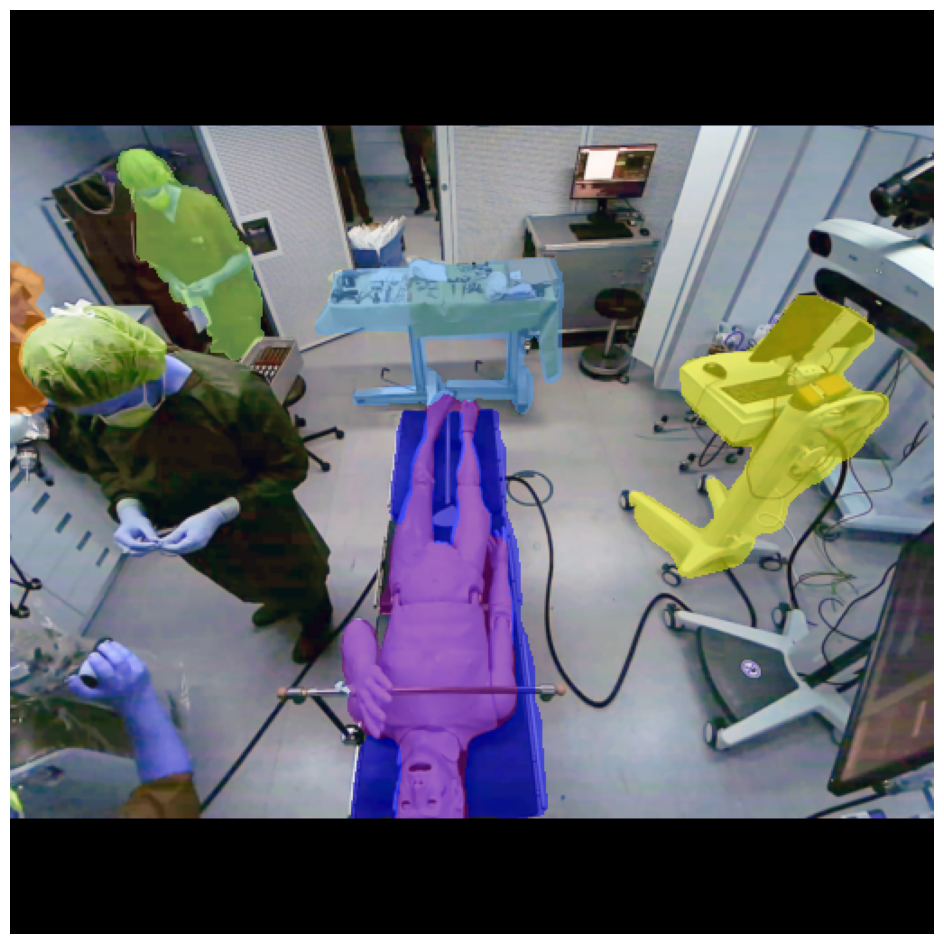

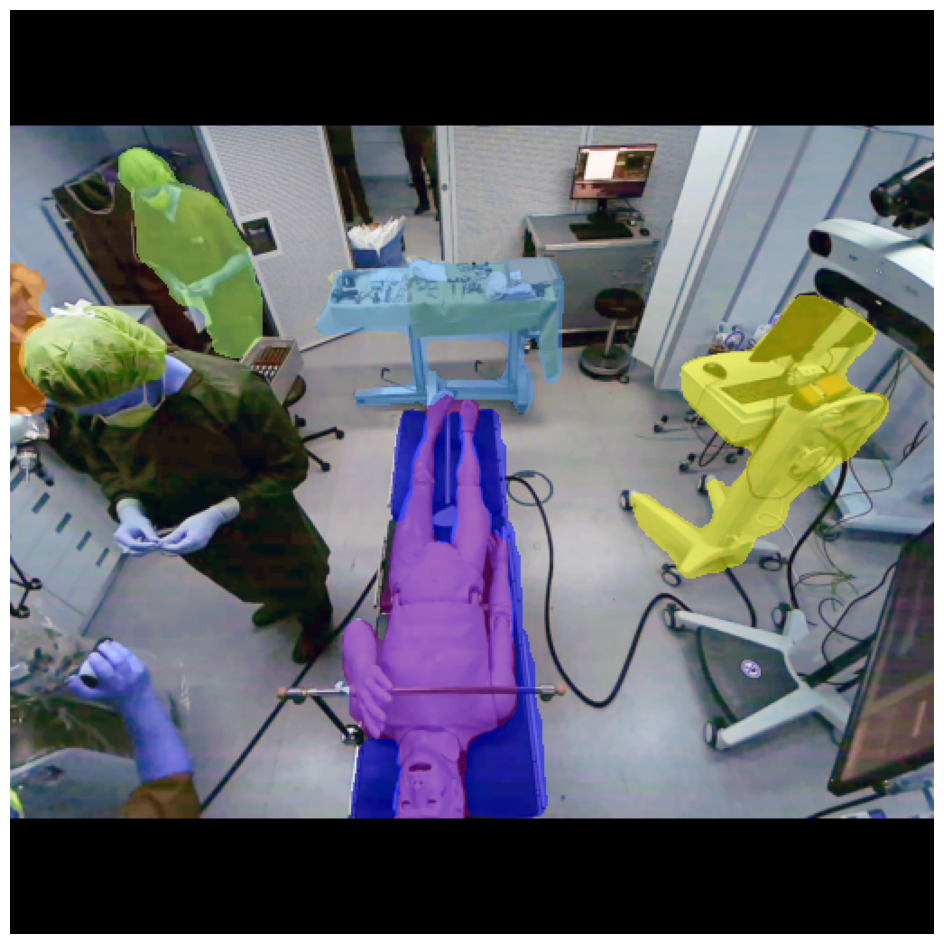

In [37]:
def get_color_map():
    color_map = []
    for k, v in LABEL_PROJECTION_MAP.items():
        r, g, b = v['color']
        color_map.append(sv.Color(r,g,b))
    color_map = sv.ColorPalette(colors=color_map)
    return color_map

# Get color map
color_map = get_color_map()

# GT masks
gt_mask = masks_val[0].cpu().numpy()
gt_class_id = gt_labels[0].cpu().numpy()
empty_bboxes = np.array([[0, 0, 0, 0]] * len(gt_class_id))

# Gt Annotated Frame 
gt_detections = sv.Detections(xyxy=empty_bboxes, mask=gt_mask, class_id=gt_class_id)
mask_annotator = sv.MaskAnnotator(color=color_map)
gt_annotated_frame = mask_annotator.annotate(
    scene=np.array(unnormalized_image),
    detections=gt_detections
)
sv.plot_image(gt_annotated_frame)

# Prediction Annotated Frame
pred_mask = (all_frame_outputs_val[0]['pred_masks_high_res'][0].sigmoid() > 0.5).bool().numpy()
pred_class_ids = best_probs.indices.numpy().astype(np.int32)
empty_bboxes = np.array([[0, 0, 0, 0]] * len(pred_class_ids))
pred_detections = sv.Detections(xyxy=empty_bboxes, mask=pred_mask, class_id=pred_class_ids)
mask_annotator = sv.MaskAnnotator(color=color_map)
pred_annotated_frame = mask_annotator.annotate(
    scene=np.array(unnormalized_image),
    detections=pred_detections
)
sv.plot_image(pred_annotated_frame)


dict_keys(['pred_masks', 'pred_masks_high_res', 'pred_logits', 'aux_outputs'])

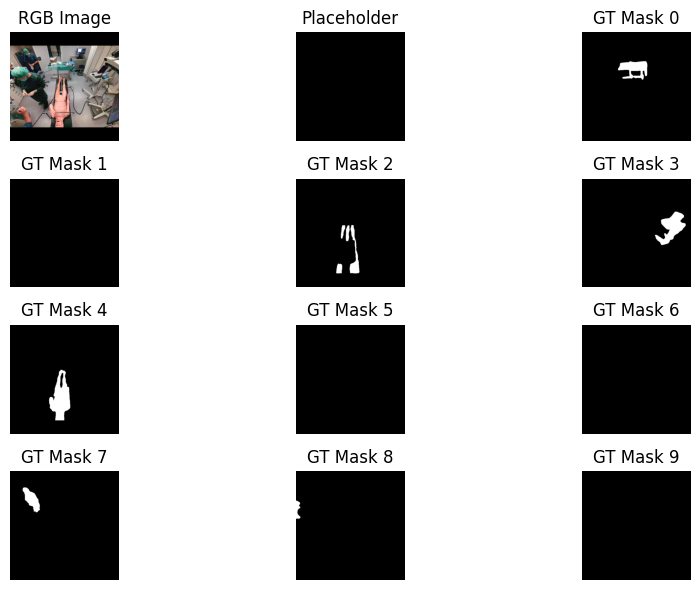

In [10]:
obj_out_idx = 0
gt_mask = masks_val[0].cpu()
black_placeholder = np.zeros_like(gt_mask[0])  # Black image placeholder

# Create figure and subplots
fig, axes = plt.subplots(4, 3, figsize=(10, 6))

# First row (RGB, GT, Black Placeholder)
axes[0, 0].imshow(unnormalized_image)
axes[0, 0].set_title("RGB Image")

axes[0, 1].imshow(black_placeholder, cmap='gray')
axes[0, 1].set_title("Placeholder")

axes[0, 2].imshow(gt_mask[0], cmap='gray')
axes[0, 2].set_title("GT Mask 0")

# Second row (GT gt_mask)
axes[1, 0].imshow(gt_mask[1], cmap='gray')
axes[1, 0].set_title("GT Mask 1")

axes[1, 1].imshow(gt_mask[2], cmap='gray')
axes[1, 1].set_title("GT Mask 2")

axes[1, 2].imshow(gt_mask[3], cmap='gray')
axes[1, 2].set_title("GT Mask 3")

# Third row (GT gt_mask)
axes[2, 0].imshow(gt_mask[4], cmap='gray')
axes[2, 0].set_title("GT Mask 4")

axes[2, 1].imshow(gt_mask[5], cmap='gray')
axes[2, 1].set_title("GT Mask 5")

axes[2, 2].imshow(gt_mask[6], cmap='gray')
axes[2, 2].set_title("GT Mask 6")

# Fourth row (GT gt_mask)
axes[3, 0].imshow(gt_mask[7], cmap='gray')
axes[3, 0].set_title("GT Mask 7")

axes[3, 1].imshow(gt_mask[8], cmap='gray')
axes[3, 1].set_title("GT Mask 8")

axes[3, 2].imshow(gt_mask[9], cmap='gray')
axes[3, 2].set_title("GT Mask 9")

# Remove axes for a cleaner look
for ax in axes.ravel():
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

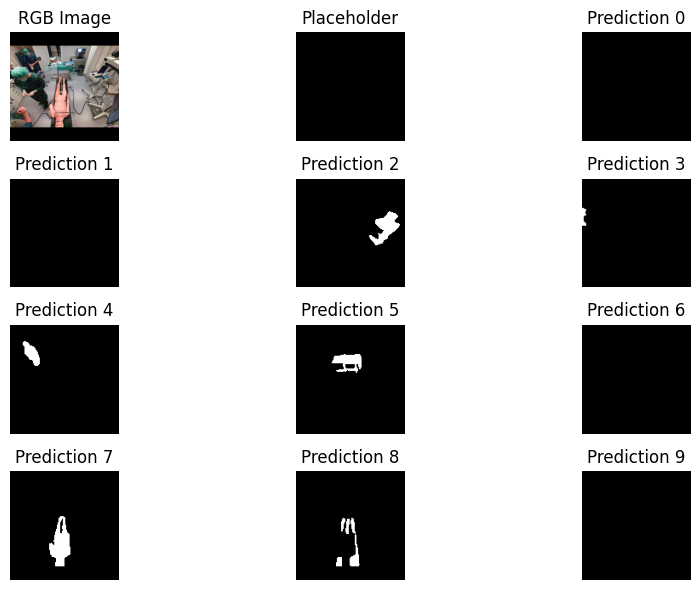

In [11]:
obj_out_idx = 0
black_placeholder = np.zeros_like(gt_mask[0])  # Black image placeholder

# Create figure and subplots
fig, axes = plt.subplots(4, 3, figsize=(10, 6))

# First row (RGB, GT, Black Placeholder)
axes[0, 0].imshow(unnormalized_image)
axes[0, 0].set_title("RGB Image")

axes[0, 1].imshow(black_placeholder, cmap='gray')
axes[0, 1].set_title("Placeholder")

axes[0, 2].imshow(masks[0], cmap='gray')
axes[0, 2].set_title("Prediction 0")

# Second row (Predictions)
axes[1, 0].imshow(masks[1], cmap='gray')
axes[1, 0].set_title("Prediction 1")

axes[1, 1].imshow(masks[2], cmap='gray')
axes[1, 1].set_title("Prediction 2")

axes[1, 2].imshow(masks[3], cmap='gray')
axes[1, 2].set_title("Prediction 3")

# Third row (Predictions)
axes[2, 0].imshow(masks[4], cmap='gray')
axes[2, 0].set_title("Prediction 4")

axes[2, 1].imshow(masks[5], cmap='gray')
axes[2, 1].set_title("Prediction 5")

axes[2, 2].imshow(masks[6], cmap='gray')
axes[2, 2].set_title("Prediction 6")

# Fourth row (Predictions)
axes[3, 0].imshow(masks[7], cmap='gray')
axes[3, 0].set_title("Prediction 7")

axes[3, 1].imshow(masks[8], cmap='gray')
axes[3, 1].set_title("Prediction 8")

axes[3, 2].imshow(masks[9], cmap='gray')
axes[3, 2].set_title("Prediction 9")

# Remove axes for a cleaner look
for ax in axes.ravel():
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()